In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import diffrax
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from exciting_environments.pmsm.pmsm_env import PMSM,step_eps,dq2albet, ROTATION_MAP
from functools import partial

2025-02-27 15:53:25.330904: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
import jax_dataclasses as jdc
from models.models import MLP

In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [4]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [5]:
from exciting_environments.pmsm.pmsm_env import PMSM,step_eps,dq2albet, ROTATION_MAP
def get_advanced_angle(eps, tau_scale, tau, omega):
    return eps + tau_scale * tau * omega

class ClassicController:
    def __init__(self, motor, saturated, a=4, decoupling=True, tau=1e-4):
        """
        Initializes the ClassicController.

        Args:
            motor (Motor): The motor object containing motor parameters.
            saturated (bool): Indicates whether the motor is saturated.
            a (int, optional): A parameter for the controller. Defaults to 4.
            decoupling (bool, optional): Indicates whether decoupling is enabled. Defaults to True.
            tau (float, optional): The time constant for the controller. Defaults to 1e-4.

        Attributes:
            p_gain (float): Proportional gain for the controller.
            i_gain (float): Integral gain for the controller.
            tau (float): The time constant for the controller.
            a (int): A parameter for the controller.
            motor (Motor): The motor object containing motor parameters.
            L_dq (float): Inductance in the dq-axis (if not saturated).
            psi_dq (float): Flux linkage in the dq-axis (if not saturated).
            batch_size (int): The batch size for processing.
            decoupling (bool): Indicates whether decoupling is enabled.
            saturated (bool): Indicates whether the motor is saturated.
            interpolators (Interpolator): Interpolators for the motor (if saturated).
            u_s_0 (float): Initial control signal.
            integrated (float): Integrated error for the controller.
        """
        self.tau: float = tau
        self.a: int = a

        self.motor= motor
        if not saturated:
            self.L_dq: float = motor.l_dq
            self.psi_dq: float = motor.psi_dq

        self.batch_size: int = None
        self.decoupling: bool = decoupling
        self.saturated: bool = saturated
        if self.saturated:
            self.interpolators = motor.LUT_interpolators
        self.u_s_0 = 0

        self.tune()

    def tune(self):
        """
        Tunes the controller by setting the proportional and integral gains.

        If the motor is not saturated, the proportional gain (p_gain) and integral gain (i_gain)
        are calculated based on the motor's inductance (L_dq), the parameter 'a', and the time constant (tau).

        Returns:
            None
        """
        if not self.saturated:
            self.p_gain = 1 / (self.a * 1.5 * self.tau) * self.L_dq
            self.i_gain = self.p_gain / ((self.a) ** 2 * 1.5 * self.tau)

    def check_constraints(self, e, eps ,integrated, p_gain, i_gain, u_s_0):
        """
        Checks whether operation points are allowed to be integrated and returns a mask.

        The mask indicates whether the operation points are within the allowed constraints.
        A value of 0 indicates "nok" and 1 indicates "ok".

        Args:
            e (np.ndarray): The error array.
            eps (float): The epsilon value.

        Returns:
            np.ndarray: A mask array where 0s indicate not okay and 1s indicate okay.
        """

        mask = jnp.zeros_like(e)
        u_dq = (
            p_gain * e
            + i_gain * (integrated + e * self.tau)
            + u_s_0
        )

        u_dq_norm = u_dq / self.motor.env_properties.action_constraints.u_d

        self.u_albet_norm = dq2albet(
            u_dq_norm,
            get_advanced_angle(eps, 0.5, self.tau, (3 * 1500 / 60 * 2 * jnp.pi)),
        )
        u_albet_c = self.u_albet_norm[:, 0] + 1j * self.u_albet_norm[:, 1]
        idx = (
            jnp.sin(jnp.angle(u_albet_c)[..., jnp.newaxis] - 2 / 3 * jnp.pi * jnp.arange(3))
            >= 0
        ).astype(int)
        rot_vecs = ROTATION_MAP[idx[:, 0], idx[:, 1], idx[:, 2]]
        u_albet_c=jnp.multiply(u_albet_c, rot_vecs)
        cond1 = (jnp.abs(u_albet_c.real) < 2 / 3) & (
            (u_albet_c.imag > 0) & (u_albet_c.imag < 2 / 3 * jnp.sqrt(3))
        )  # Inside
        cond2 = (
            ~(jnp.abs(u_albet_c.real) < 2 / 3)
            | ((u_albet_c.imag < 0) | (u_albet_c.imag > 2 / 3 * jnp.sqrt(3)))
        ) & jnp.all(
            e < 0, axis=1
        )  # outside but neg

        mask = jnp.logical_or(cond1, cond2)
        return mask

    def integrate(self, integrated,e, mask):
        """
        Integrates the error over time with the given mask.

        Args:
            e (np.ndarray): The error array.
            mask (np.ndarray): The mask array indicating which errors to integrate.

        Returns:
            None
        """
        #integrated += e * self.tau * mask
        integrated = (integrated + e * self.tau )* mask
        return integrated

    def __call__(self, obs , integrated):
        """
        Computes the control action based on the observed state.

        Args:
            obs (np.ndarray): The observation array containing the normalized state, epsilon, and reference values.

        Returns:
            np.ndarray: The normalized control action voltages.
        """
        # Extract normalized state, epsilon, and reference values from the observation
        state_norm = obs[:, :2]
        eps = obs[:, 2:3]
        reference_norm = obs[:, 3:5]

        # Calculate the error between the reference and the current state
        e = (reference_norm - state_norm) * self.motor.env_properties.physical_constraints.i_d

        if self.saturated:
            # Tune gains if the motor is saturated
            p_d = {
                q: interp(state_norm * self.motor.env_properties.physical_constraints.i_d)
                for q, interp in self.interpolators.items()
            }
            # Neglect non-main-diagonal entries of L_diff
            L_dq = jnp.column_stack([p_d[q] for q in ["L_dd", "L_qq"]])
            psi_dq = jnp.column_stack([p_d[q] for q in ["Psi_d", "Psi_q"]])
            p_gain = 1 / (self.a * 1.5 * self.tau) * L_dq
            p_gain_help = 1 / (self.a * 1.5 * self.tau) * L_dq
            i_gain = 0.3*p_gain_help / ((self.a) ** 2 * 1.5 * self.tau)

        if self.decoupling:
            # Apply decoupling if enabled
            i_dq = state_norm * self.motor.env_properties.physical_constraints.i_d
            q = jnp.array([0, -1, 1, 0]).reshape(2, 2)
            if self.saturated:
                # Calculate the initial control signal for saturated motor
                u_s_0 = (3 * 1500 / 60 * 2 * jnp.pi) * jnp.einsum(
                    "ij,bj->bi", q, psi_dq
                )
            else:
                # Calculate the initial control signal for non-saturated motor
                u_s_0 = (3 * 1500 / 60 * 2 * jnp.pi) * jnp.einsum(
                    "ij,bj->bi", q, i_dq * L_dq + psi_dq
                )
        else: u_s_0=self.u_s_0

        # Check constraints and get the integration allowance mask
        integration_allowance_mask = self.check_constraints(e, eps, integrated, p_gain, i_gain, u_s_0)
        # Integrate the error with the mask
        integrated=self.integrate(integrated,e,integration_allowance_mask)
        # Calculate the control action
        u_dq = p_gain * e + i_gain * integrated + u_s_0

        # Normalize the control action voltages
        return u_dq / self.motor.env_properties.action_constraints.u_d, integrated

    def reset(self, batch_size):
        """
        Resets the controller's state for a new batch of data.

        Args:
            batch_size (int): The size of the new batch.

        Returns:
            None
        """
        self.batch_size = batch_size
        
        return jnp.zeros((self.batch_size, 2))

    def parameters(self):
        """
        Returns the parameters of the controller.

        Returns:
            list: An empty list of parameters.
        """
        return []

In [6]:
# ROTATION_MAP_np=np.array(ROTATION_MAP)
# t32_np = np.array([[1, 0], [-0.5, 0.5 * np.sqrt(3)], [-0.5, -0.5 * np.sqrt(3)]])  # only for alpha/beta -> abc
# t23_np = 2 / 3 * np.array([[1, 0], [-0.5, 0.5 * np.sqrt(3)], [-0.5, -0.5 * np.sqrt(3)]]).T  # only for abc -> alpha/beta
# def t_dq_alpha_beta_np(eps):
#     """Compute the transformation matrix for converting between DQ and Alpha-Beta reference frames."""
#     cos = np.cos(eps)
#     sin = np.sin(eps)
#     return np.column_stack((cos, sin, -sin, cos)).reshape(2, 2)


# def dq2abc_np(u_dq, eps):
#     """Transform voltages from DQ coordinates to ABC (three-phase) coordinates."""
#     u_abc = t32_np @ dq2albet_np(u_dq, eps).T
#     return u_abc.T


# def dq2albet_np(u_dq, eps):
#     """Transform voltages from DQ coordinates to Alpha-Beta coordinates."""
#     q = t_dq_alpha_beta_np(-eps)
#     u_alpha_beta = q @ u_dq.T

#     return u_alpha_beta.T
# class ClassicControllerNP:
#     def __init__(self, motor, saturated, a=4, decoupling=True, tau=1e-4):
#         """
#         Initializes the ClassicController.

#         Args:
#             motor (Motor): The motor object containing motor parameters.
#             saturated (bool): Indicates whether the motor is saturated.
#             a (int, optional): A parameter for the controller. Defaults to 4.
#             decoupling (bool, optional): Indicates whether decoupling is enabled. Defaults to True.
#             tau (float, optional): The time constant for the controller. Defaults to 1e-4.

#         Attributes:
#             p_gain (float): Proportional gain for the controller.
#             i_gain (float): Integral gain for the controller.
#             tau (float): The time constant for the controller.
#             a (int): A parameter for the controller.
#             motor (Motor): The motor object containing motor parameters.
#             L_dq (float): Inductance in the dq-axis (if not saturated).
#             psi_dq (float): Flux linkage in the dq-axis (if not saturated).
#             batch_size (int): The batch size for processing.
#             decoupling (bool): Indicates whether decoupling is enabled.
#             saturated (bool): Indicates whether the motor is saturated.
#             interpolators (Interpolator): Interpolators for the motor (if saturated).
#             u_s_0 (float): Initial control signal.
#             integrated (float): Integrated error for the controller.
#         """
#         self.p_gain: float = None
#         self.i_gain: float = None
#         self.tau: float = tau
#         self.a: int = a

#         self.motor= motor
#         if not saturated:
#             self.L_dq: float = motor.l_dq
#             self.psi_dq: float = motor.psi_dq

#         self.batch_size: int = None
#         self.decoupling: bool = decoupling
#         self.saturated: bool = saturated
#         if self.saturated:
#             self.interpolators = motor.LUT_interpolators
#         self.u_s_0 = 0

#         self.integrated = None
#         self.tune()

#     def tune(self):
#         """
#         Tunes the controller by setting the proportional and integral gains.

#         If the motor is not saturated, the proportional gain (p_gain) and integral gain (i_gain)
#         are calculated based on the motor's inductance (L_dq), the parameter 'a', and the time constant (tau).

#         Returns:
#             None
#         """
#         if not self.saturated:
#             self.p_gain = 1 / (self.a * 1.5 * self.tau) * self.L_dq
#             self.i_gain = self.p_gain / ((self.a) ** 2 * 1.5 * self.tau)

#     def check_constraints(self, e, eps):
#         """
#         Checks whether operation points are allowed to be integrated and returns a mask.

#         The mask indicates whether the operation points are within the allowed constraints.
#         A value of 0 indicates "nok" and 1 indicates "ok".

#         Args:
#             e (np.ndarray): The error array.
#             eps (float): The epsilon value.

#         Returns:
#             np.ndarray: A mask array where 0s indicate not okay and 1s indicate okay.
#         """

#         mask = np.zeros_like(e)
#         u_dq = (
#             self.p_gain * e
#             + self.i_gain * (self.integrated + e * self.tau)
#             + self.u_s_0
#         )

#         u_dq_norm = u_dq / self.motor.env_properties.action_constraints.u_d

#         self.u_albet_norm = dq2albet_np(
#             u_dq_norm,
#             get_advanced_angle(eps, 0.5, self.tau, (3 * 1500 / 60 * 2 * np.pi)),
#         )
#         u_albet_c = self.u_albet_norm[:, 0] + 1j * self.u_albet_norm[:, 1]
#         idx = (
#             np.sin(np.angle(u_albet_c)[..., np.newaxis] - 2 / 3 * np.pi * np.arange(3))
#             >= 0
#         ).astype(int)
#         rot_vecs = ROTATION_MAP_np[idx[:, 0], idx[:, 1], idx[:, 2]]
#         np.multiply(u_albet_c, rot_vecs, out=u_albet_c)
#         cond1 = (np.abs(u_albet_c.real) < 2 / 3) & (
#             (u_albet_c.imag > 0) & (u_albet_c.imag < 2 / 3 * np.sqrt(3))
#         )  # Inside
#         cond2 = (
#             ~(np.abs(u_albet_c.real) < 2 / 3)
#             | ((u_albet_c.imag < 0) | (u_albet_c.imag > 2 / 3 * np.sqrt(3)))
#         ) & np.all(
#             e < 0, axis=1
#         )  # outside but neg
#         #mask[cond1 | cond2] = 1
#         mask=np.logical_or(cond1,cond2)

#         return mask

#     def integrate(self, e, mask):
#         """
#         Integrates the error over time with the given mask.

#         Args:
#             e (np.ndarray): The error array.
#             mask (np.ndarray): The mask array indicating which errors to integrate.

#         Returns:
#             None
#         """
#         self.integrated += e * self.tau * mask

#     def __call__(self, obs):
#         """
#         Computes the control action based on the observed state.

#         Args:
#             obs (np.ndarray): The observation array containing the normalized state, epsilon, and reference values.

#         Returns:
#             np.ndarray: The normalized control action voltages.
#         """
#         # Extract normalized state, epsilon, and reference values from the observation
#         state_norm = obs[:, :2]
#         eps = obs[:, 2:3]
#         reference_norm = obs[:, 3:5]

#         # Calculate the error between the reference and the current state
#         e = (reference_norm - state_norm) * self.motor.env_properties.physical_constraints.i_d

#         if self.saturated:
#             # Tune gains if the motor is saturated
#             p_d = {
#                 q: interp(state_norm * self.motor.env_properties.physical_constraints.i_d)
#                 for q, interp in self.interpolators.items()
#             }
#             # Neglect non-main-diagonal entries of L_diff
#             self.L_dq = np.column_stack([np.array(p_d[q], copy=False) for q in ["L_dd", "L_qq"]])
#             self.psi_dq = np.column_stack([np.array(p_d[q], copy=False) for q in ["Psi_d", "Psi_q"]])
#             self.p_gain = 1 / (self.a * 1.5 * self.tau) * self.L_dq
#             self.i_gain = self.p_gain / ((self.a) ** 2 * 1.5 * self.tau)

#         if self.decoupling:
#             # Apply decoupling if enabled
#             i_dq = state_norm * self.motor.env_properties.physical_constraints.i_d
#             q = np.array([0, -1, 1, 0]).reshape(2, 2)
#             if self.saturated:
#                 # Calculate the initial control signal for saturated motor
#                 self.u_s_0 = (3 * 1500 / 60 * 2 * np.pi) * np.einsum(
#                     "ij,bj->bi", q, self.psi_dq
#                 )
#             else:
#                 # Calculate the initial control signal for non-saturated motor
#                 self.u_s_0 = (3 * 1500 / 60 * 2 * np.pi) * np.einsum(
#                     "ij,bj->bi", q, i_dq * self.L_dq + self.psi_dq
#                 )

#         # Check constraints and get the integration allowance mask
#         integration_allowance_mask = self.check_constraints(e, eps)
#         # Integrate the error with the mask
#         self.integrate(e, integration_allowance_mask)
#         # Calculate the control action
#         u_dq = self.p_gain * e + self.i_gain * self.integrated + self.u_s_0

#         # Normalize the control action voltages
#         return u_dq / self.motor.env_properties.action_constraints.u_d

#     def reset(self, batch_size):
#         """
#         Resets the controller's state for a new batch of data.

#         Args:
#             batch_size (int): The size of the new batch.

#         Returns:
#             None
#         """
#         self.batch_size = batch_size
#         self.integrated = np.zeros((self.batch_size, 2))

#     def parameters(self):
#         """
#         Returns the parameters of the controller.

#         Returns:
#             list: An empty list of parameters.
#         """
#         return []

In [7]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng) 
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

Function returns random initial_observation and reference_observation the dpc should target while training:

Featurize function for the dpc policy - feat_obs is input of the dpc_policy network:

In [8]:
def actor(action):
   #due to use of feature_state as integrated action is already computed in featurize to fit the framework
    return action[0]

## Evaluate on pmsm_env (motor_env):

In [9]:
from utils.evaluation import steps_eval
from utils.signals import steps_ref_traj
from utils.visualization import plot_i_dq_ref_tracking_time

In [10]:
# @eqx.filter_jit
# def featurize_np(obs,ref_obs, featurize_state=jnp.array([0,0])):
#     eps=jnp.arctan2(obs[5],obs[4])
#     i_dq_norm=jnp.array([(obs[0]*0.5-0.5),obs[1]])
#     ref_norm=jnp.array([(ref_obs[0]*0.5-0.5),ref_obs[1]])
#     feat_obs=jnp.hstack([i_dq_norm,eps,ref_norm])
#     return feat_obs[None,:],featurize_state

# def actor2(feat_obs):
#     feat_obs_np=np.array(feat_obs)
#     return jnp.array(controller2(feat_obs_np)[0])
# # @eqx.filter_jit
# def rollout_traj_env_policy_np(policy, init_obs, ref_obs, horizon_length, env, featurize):
#     init_state = env.generate_state_from_observation(init_obs, env.env_properties)

#     if len(ref_obs.shape) == 1:
#         ref_o = np.repeat(ref_obs[None, :], horizon_length, axis=0)
#     else:
#         ref_o = ref_obs
#         assert ref_obs.shape[0] == horizon_length

#     _, init_feat_state = featurize(init_obs, ref_o[0])
#     init_feat_state = np.zeros_like(init_feat_state)

#     observations=[]
#     observations.append(init_obs)
#     obs=init_obs
#     state=init_state
#     feat_state=init_feat_state
#     actions=[]


#     for i in range(horizon_length):
    
#         policy_in, feat_state = featurize(obs, ref_o[i], feat_state)

#         action = policy(policy_in)

#         obs, state = env.step(state, action, env.env_properties)

#         observations.append(obs)
#         actions.append(action)

#     return np.array(observations), np.array(actions)

# def steps_eval_np(env, reset_fun, policy, featurize, key, ref_len, init_obs_key=None, plot=True, step_lens=[50, 200]):
#     obs_ref = steps_ref_traj(env, reset_fun, key, ref_len, step_lens=step_lens)
#     init_obs = reset_fun(env, init_obs_key)
#     obs, acts = rollout_traj_env_policy_np(policy, init_obs, obs_ref, ref_len, env, featurize)
#     if plot:
#         fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
#         plot_i_dq_ref_tracking_time(obs, obs_ref, axes, tau=env.tau)
#     return obs, obs_ref, acts

In [11]:
# controller2.reset(batch_size=1)
# obs,obs_ref,acts=steps_eval_np(motor_env,reset,actor2,featurize_np,jax.random.PRNGKey(2),500)

In [12]:
controller=ClassicController(motor=motor_env,a=4,saturated=True,decoupling=True)
@eqx.filter_jit
def featurize(obs,ref_obs, integrated=jnp.array([[0,0]])):
    eps=jnp.arctan2(obs[5],obs[4])
    i_dq_norm=jnp.array([(obs[0]*0.5-0.5),obs[1]])
    ref_norm=jnp.array([(ref_obs[0]*0.5-0.5),ref_obs[1]])
    feat_obs=jnp.hstack([i_dq_norm,eps,ref_norm])[None,:]
    act,integrated=controller(feat_obs,integrated)
    return act,integrated

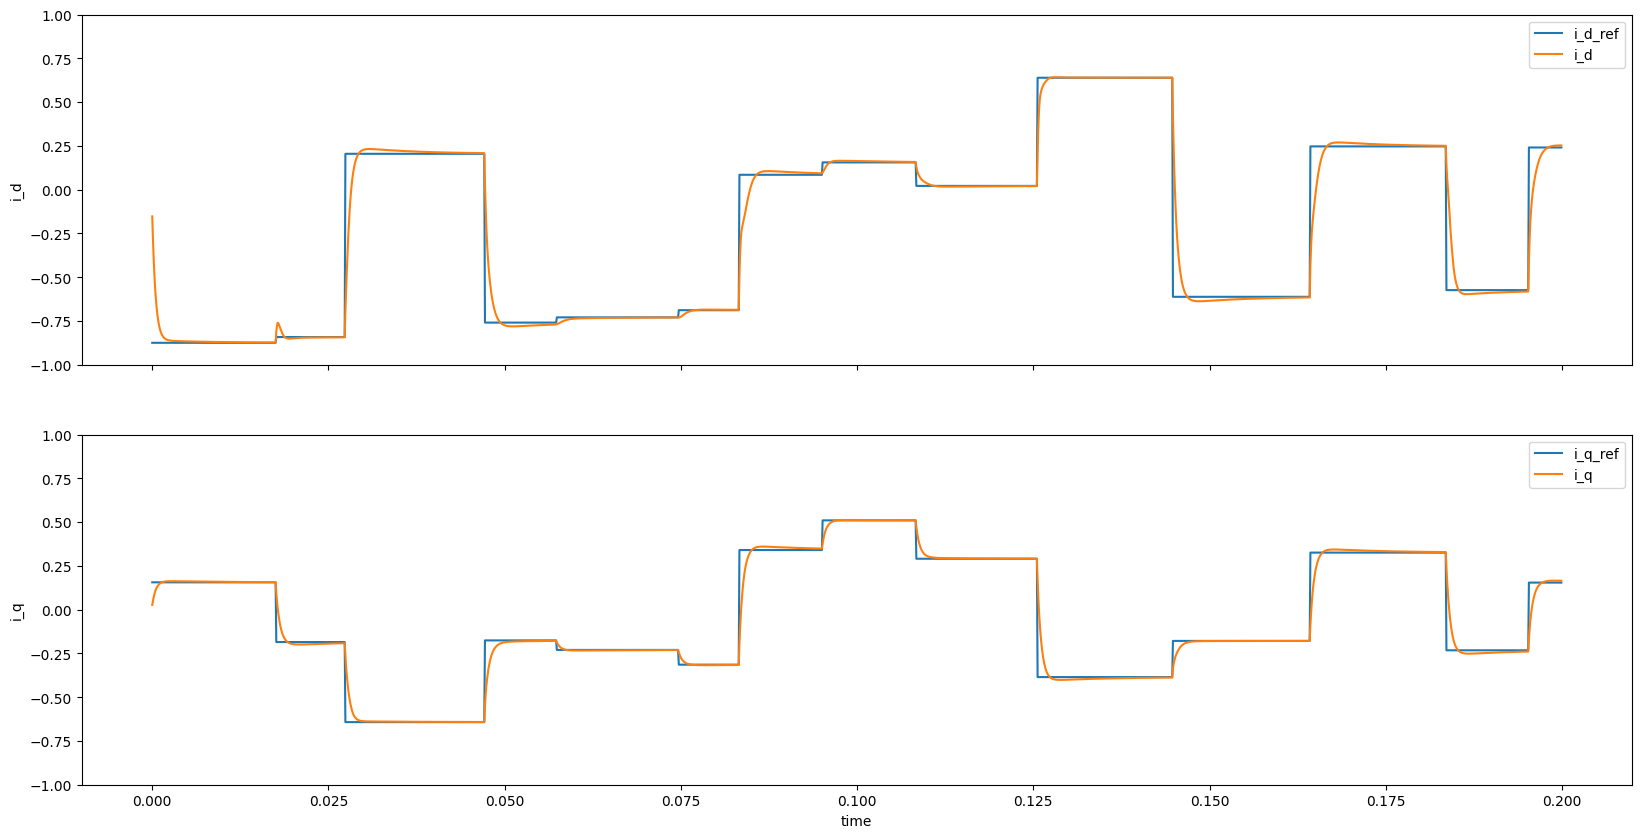

In [13]:
#_=controller.reset(batch_size=1)
obs,obs_ref,acts=steps_eval(motor_env,reset,actor,featurize,jax.random.PRNGKey(5),2000,plot=True)